In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, filters
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from skimage.feature import hog
from sklearn.decomposition import PCA
from skimage.transform import resize
from skimage import img_as_ubyte


In [3]:
# Code Snippet 1: Function to get bounding boxes from Annotations
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

In [4]:
# Code Snippet 2: Cropping and Resizing Images
def process_images(dog_images, annotations):
    for i in range(len(dog_images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = io.imread(dog_images[i])
        for j in range(len(bbox)):
            im2 = dog[bbox[j][1]:bbox[j][3], bbox[j][0]:bbox[j][2]]

            # Check if the cropped region is not empty before resizing
            if im2.size > 0:
                im2 = resize(im2, (128, 128), anti_aliasing=True)

                # Convert image to 8-bit unsigned integer format
                im2 = img_as_ubyte(im2)

                new_path = dog_images[i].replace('rajani images', 'Cropped').replace('.jpg', f'-{j}.jpg')

                # Create the directory if it doesn't exist
                os.makedirs(os.path.dirname(new_path), exist_ok=True)

                io.imsave(new_path, im2)



In [5]:
# Task 2: Image Processing
def image_processing(dog_images):
    selected_images = []
    for dog_class in dog_images.keys():
        selected_images.append(dog_images[dog_class][0])  # Select only the first image

    for img_path in selected_images:
        img = io.imread(img_path)
        gray_img = color.rgb2gray(img)
        plt.subplot(2, 2, selected_images.index(img_path) + 1)
        plt.imshow(gray_img, cmap='gray')
        plt.title('Gray Image')

    plt.show()

    # Plot pixel intensity histograms
    plt.figure(figsize=(10, 5))
    for img_path in selected_images:
        img = io.imread(img_path)
        gray_img = color.rgb2gray(img)
        hist, bins = exposure.histogram(gray_img, nbins=256)
        plt.plot(bins, hist, label=img_path.split(os.path.sep)[-2])

    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Histograms')
    plt.legend()
    plt.show()

    # Edge detection
    plt.figure(figsize=(10, 5))
    for img_path in selected_images:
        img = io.imread(img_path)
        gray_img = color.rgb2gray(img)
        edges = filters.sobel(gray_img)
        plt.subplot(2, 2, selected_images.index(img_path) + 1)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Image')

    plt.show()


In [6]:
# Edge histogram
def edge_histogram(selected_image):
    img = io.imread(selected_image)
    gray_img = color.rgb2gray(img)
    dx, dy = np.gradient(gray_img)
    angle_sobel = np.mod(np.arctan2(dy, dx), np.pi)
    hist, bins = exposure.histogram(angle_sobel, nbins=36)

    plt.subplot(1, 2, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.bar(bins, hist, width=np.pi / 18)
    plt.xlabel('Bins')
    plt.ylabel('Pixel Count')
    plt.title('Edge Histogram')

    plt.show()

In [7]:
# Task 2d: Histogram Comparison
def histogram_comparison(img_path1, img_path2, img_path3):
    # Read images
    img1 = io.imread(img_path1)
    img2 = io.imread(img_path2)
    img3 = io.imread(img_path3)

    # Convert images to grayscale
    gray_img1 = color.rgb2gray(img1)
    gray_img2 = color.rgb2gray(img2)
    gray_img3 = color.rgb2gray(img3)

    # Compute histograms
    hist1, bins1 = exposure.histogram(gray_img1, nbins=256)
    hist2, bins2 = exposure.histogram(gray_img2, nbins=256)
    hist3, bins3 = exposure.histogram(gray_img3, nbins=256)

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.plot(bins1, hist1, label='Image 1')
    plt.plot(bins2, hist2, label='Image 2')
    plt.plot(bins3, hist3, label='Image 3')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram Comparison')
    plt.legend()
    plt.show()


In [8]:
# Task 2e: Histogram of Oriented Gradient (HOG) feature descriptor
def hog_descriptor(img_path):
    # Read the image
    img = io.imread(img_path)

    # Convert the image to grayscale
    gray_img = color.rgb2gray(img)

    # Compute HOG descriptors
    orientations = 9  # You can adjust this value based on your requirements
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)

    hog_features, hog_image = hog(gray_img, orientations=orientations,
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block,
                                  block_norm='L2-Hys',
                                  visualize=True, multichannel=False)

    # Plot the image and HOG descriptors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    ax1.imshow(gray_img, cmap=plt.cm.gray)
    ax1.set_title('Input Image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

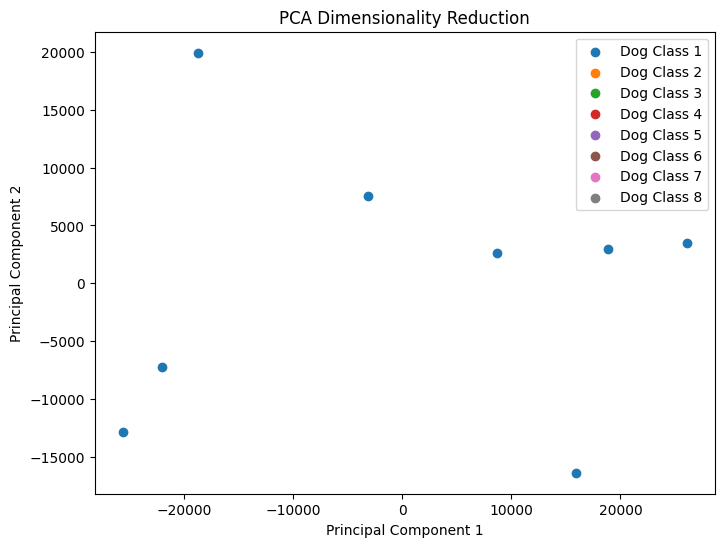

In [10]:
# Task 2f: Dimensionality reduction (using Principal Component Analysis, PCA)
def pca_dimensionality_reduction(hist_vectors):
    if not hist_vectors:
        print("Error: Input array is empty.")
        return

    # Convert the list of histograms to a 2D array
    X = np.vstack(hist_vectors)

    # Perform PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X)

    # Plot the 2D points using different colors for data from the 2 classes
    plt.figure(figsize=(8, 6))
    for i, dog_class in enumerate(hist_vectors):
        plt.scatter(reduced_data[i * len(dog_class):(i + 1) * len(dog_class), 0],
                    reduced_data[i * len(dog_class):(i + 1) * len(dog_class), 1],
                    label=f'Dog Class {i + 1}')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Dimensionality Reduction')
    plt.legend()
    plt.show()

dog_images = {
    'n02105412-kelpie': ['./Data/n02105412-kelpie/n02105412_1031.jpg','./Data/n02105412-kelpie/n02105412_1078.jpg'],  # List of image paths for class 'n02105412-kelpie'
    'n02102480-Sussex_spaniel': ['./Data/n02102480-Sussex_spaniel/n02102480_101.jpg','./Data/n02102480-Sussex_spaniel/n02102480_105.jpg'],  # List of image paths for class 'n02102480-Sussex_spaniel'
    'n02093991-Irish_terrier': ['./Data/n02093991-Irish_terrier/n02093991_1026.jpg','./Data/n02093991-Irish_terrier/n02093991_1038.jpg'],
    'n02098413-Lhasa': ['./Data/n02098413-Lhasa/n02098413_10144.jpg','./Data/n02098413-Lhasa/n02098413_10285.jpg'],
    # Add paths for other classes
}

# Generate histograms
hist_vectors = []
for dog_class, img_paths in dog_images.items():
    for img_path in img_paths:
        img = io.imread(img_path)
        gray_img = color.rgb2gray(img)
        hist, _ = exposure.histogram(gray_img, nbins=36)
        hist_vectors.append(hist)

# Call the pca_dimensionality_reduction function with the generated histograms
pca_dimensionality_reduction(hist_vectors)

In [11]:
# Main execution
dog_images_folder = './Data/'
annotations_folder = './Annotations/'

In [12]:
dog_images = {}
annotations = {}

In [13]:
# Load images and annotations
for folder_name in os.listdir(dog_images_folder):
    folder_path = os.path.join(dog_images_folder, folder_name)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]
    dog_images[folder_name] = images

for folder_name in os.listdir(annotations_folder):
    folder_path = os.path.join(annotations_folder, folder_name)
    annotations[folder_name] = [os.path.join(folder_path, annot) for annot in os.listdir(folder_path)]

In [14]:
# Task 1: Cropping and Resize Images
process_images(dog_images['n02105412-kelpie'], annotations['n02105412-kelpie'])

IndexError: list index out of range

In [ ]:
# Task 2: Image Processing
image_processing(dog_images)

In [ ]:
# Task 2c: Edge histogram
selected_image = dog_images['n02105412-kelpie'][0]  # Select one image for edge histogram
edge_histogram(selected_image)

In [ ]:
# Task 2d: Histogram Comparison
histogram_comparison(dog_images['n02105412-kelpie'][0], dog_images['n02105412-kelpie'][1], dog_images['n02098413-Lhasa'][0])


In [ ]:
# Task 2e: Histogram of Oriented Gradient (HOG) feature descriptor
hog_descriptor(dog_images['n02105412-kelpie'][0])

In [ ]:
# Print the keys in dog_images dictionary
print("Keys in dog_images:", dog_images.keys())

In [ ]:
# Task 2f: Dimensionality reduction (using Principal Component Analysis, PCA)
hist_vectors = []

# Replace '...' with the actual paths to images for each class
for img_path in dog_images['n02105412-kelpie'][:2] + dog_images['n02093991-Irish_terrier'][:2]:
    img = io.imread(img_path)
    gray_img = color.rgb2gray(img)
    hist, _ = exposure.histogram(gray_img, nbins=36)
    hist_vectors.append(hist)

In [ ]:
pca_dimensionality_reduction(hist_vectors)